<a href="https://colab.research.google.com/github/StillWork/AIPM/blob/main/02_penicillin_yield_prediction_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 페니실린 생산량 예측 모델 개발

**프로젝트 목표**: 제약 공정 데이터를 사용하여 0.2시간 뒤의 페니실린 농도를 예측하는 머신러닝 회귀 모델을 구축합니다.

## 1. 라이브러리 임포트 및 초기 설정

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import re
import platform
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
%config InlineBackend.figure_format = 'retina'
# 스타일 설정
# plt.style.use('seaborn-v0_8-whitegrid')
# sns.set_palette('viridis')

In [ ]:
# prompt: set retina display

import matplotlib.pyplot as plt
try:
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats('retina')
except ImportError:
  pass

# 스타일 설정
# plt.style.use('seaborn-v0_8-whitegrid')
# sns.set_palette('viridis')

### 한글 폰트 설정 (그래프 깨짐 방지)

matplotlib의 기본 폰트는 한글을 지원하지 않아 그래프의 한글이 깨져 보일 수 있습니다. 아래 코드는 시스템에 **나눔고딕(NanumGothic)** 폰트가 설치되어 있다고 가정하고, 그래프의 폰트를 설정합니다.

만약 폰트가 설치되어 있지 않다면, **아래 셀의 주석을 해제하고 실행하여 폰트를 설치한 후, 주피터 노트북의 [Kernel] -> [Restart]를 선택하여 커널을 재시작**해주세요. (최초 1회만 필요)

In [ ]:

# # 운영체제에 맞는 한글 폰트 설정
# system_name = platform.system()
# if system_name == 'Linux':
#     plt.rc('font', family='NanumGothic') # 나눔고딕 사용
# elif system_name == 'Windows':
#     plt.rc('font', family='Malgun Gothic') # 맑은 고딕 사용
# elif system_name == 'Darwin': # Mac OS
#     plt.rc('font', family='AppleGothic')
# else:
#     # 기타 시스템의 경우, 적절한 폰트 이름을 지정해야 합니다.
#     pass

# # 마이너스 부호가 깨지는 문제 해결
# plt.rc('axes', unicode_minus=False)

# print(f"시스템: {system_name}")
# print(f"Matplotlib 폰트: {plt.rcParams['font.family']}")

## 2. 데이터 로딩 및 탐색

In [2]:
# 라만 스펙트럼이 제거된 데이터 파일을 로드합니다.
file_path = 'https://raw.githubusercontent.com/tonywjs/AI_in_pharmaceutical_manufacturing_250623/refs/heads/main/Mendeley_data/100_Batches_IndPenSim_V3_no_raman.csv'
df = pd.read_csv(file_path)

print(f"데이터 형태: {df.shape}")
df[:20]

데이터 형태: (113935, 37)


,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),...,Offline Biomass concentratio(X_offline:X(g L^{-1})),Carbon evolution rate(CER:g/h),Ammonia shots(NH3_shots:kgs),Viscosity(Viscosity_offline:centPoise),Fault reference(Fault_ref:Fault ref),0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref),2-PAT control(PAT_ref:PAT ref),Batch reference(Batch_ref:Batch ref),Batch ID,Fault flag
0,0.2,30,100,8,0.0000,30.1180,9.83350,0.0001,0,0.6,...,NaN,0.034045,0,NaN,0,0,1,1,1,0
1,0.4,30,100,8,0.0000,51.2210,18.15500,0.0001,0,0.6,...,NaN,0.038702,0,NaN,0,0,1,1,1,0
2,0.6,30,100,8,0.0000,54.3020,9.59820,0.0001,0,0.6,...,NaN,0.040240,0,NaN,0,0,1,1,1,0
3,0.8,30,100,8,0.0000,37.8160,4.33950,0.0001,0,0.6,...,NaN,0.041149,0,NaN,0,0,1,1,1,0
4,1.0,30,100,8,0.5181,18.9080,1.10450,0.0001,0,0.6,...,0.52808,0.041951,0,4.083,0,0,1,1,1,0
5,1.2,30,100,8,1.0387,9.4541,0.00010,0.0001,0,0.6,...,NaN,0.042758,0,NaN,0,0,1,1,1,0
6,1.4,30,100,8,1.5604,4.7270,0.00010,0.0001,0,0.6,...,NaN,0.043599,0,NaN,0,0,1,1,1,0
7,1.6,30,100,8,2.0823,2.3635,0.00010,0.0001,0,0.6,...,NaN,0.044478,0,NaN,0,0,1,1,1,0
8,1.8,30,100,8,0.0000,0.0000,0.00010,0.0001,0,0.6,...,NaN,0.045398,0,NaN,0,0,1,1,1,0
9,2.0,30,100,8,0.0000,0.0000,0.51077,0.0001,0,0.6,...,NaN,0.046361,0,NaN,0,0,1,1,1,0


In [ ]:
df.columns

Index(['Time (h)', 'Aeration rate(Fg:L/h)', 'Agitator RPM(RPM:RPM)',
       'Sugar feed rate(Fs:L/h)', 'Acid flow rate(Fa:L/h)',
       'Base flow rate(Fb:L/h)', 'Heating/cooling water flow rate(Fc:L/h)',
       'Heating water flow rate(Fh:L/h)',
       'Water for injection/dilution(Fw:L/h)',
       'Air head pressure(pressure:bar)', 'Dumped broth flow(Fremoved:L/h)',
       'Substrate concentration(S:g/L)',
       'Dissolved oxygen concentration(DO2:mg/L)',
       'Penicillin concentration(P:g/L)', 'Vessel Volume(V:L)',
       'Vessel Weight(Wt:Kg)', 'pH(pH:pH)', 'Temperature(T:K)',
       'Generated heat(Q:kJ)',
       'carbon dioxide percent in off-gas(CO2outgas:%)',
       'PAA flow(Fpaa:PAA flow (L/h))',
       'PAA concentration offline(PAA_offline:PAA (g L^{-1}))',
       'Oil flow(Foil:L/hr)',
       'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))',
       'Oxygen Uptake Rate(OUR:(g min^{-1}))',
       'Oxygen in percent in off-gas(O2:O2  (%))',
       'Offline Penicil

## 3. 피처 엔지니어링 (Feature Engineering)

시계열 데이터를 그대로 모델에 사용하기는 어렵습니다. 대신, 각 배치의 공정 초반 데이터를 요약하는 통계적 특성을 추출하여 사용합니다.

1.  **예측 시점 정의**: 공정 시작 후 **40시간**까지의 데이터를 사용하여 최종 생산량을 예측한다고 가정합니다.
2.  **입력 특성 (X)**: 각 배치별로 40시간까지의 주요 공정 변수(온도, pH, 교반 속도 등)들의 `평균`, `표준편차`, `최소값`, `최대값`을 계산하여 새로운 특성을 만듭니다.
3.  **목표 변수 (y)**: 각 배치의 **최종 페니실린 농도**를 예측 대상으로 삼습니다. 여기서는 각 배치의 `Penicillin concentration(P:g/L)`의 최대값을 최종 생산량으로 간주합니다.

In [ ]:
# prompt: df의 전반적인  특성을 이해하기 위한 탐색적 분석 코드를 작성해줘

import matplotlib.pyplot as plt
import numpy as np
# 데이터프레임 정보 요약
print("\n--- 데이터프레임 정보 ---")
df.info()



--- 데이터프레임 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113935 entries, 0 to 113934
Data columns (total 37 columns):
 #   Column                                                              Non-Null Count   Dtype  
---  ------                                                              --------------   -----  
 0   Time (h)                                                            113935 non-null  float64
 1   Aeration rate(Fg:L/h)                                               113935 non-null  int64  
 2   Agitator RPM(RPM:RPM)                                               113935 non-null  int64  
 3   Sugar feed rate(Fs:L/h)                                             113935 non-null  int64  
 4   Acid flow rate(Fa:L/h)                                              113935 non-null  float64
 5   Base flow rate(Fb:L/h)                                              113935 non-null  float64
 6   Heating/cooling water flow rate(Fc:L/h)                             113935 non-nu

In [3]:
# 결측치 확인
print("\n--- 결측치 확인 ---")
print(df.isnull().sum())


--- 결측치 확인 ---
Time (h)                                                                   0
Aeration rate(Fg:L/h)                                                      0
Agitator RPM(RPM:RPM)                                                      0
Sugar feed rate(Fs:L/h)                                                    0
Acid flow rate(Fa:L/h)                                                     0
Base flow rate(Fb:L/h)                                                     0
Heating/cooling water flow rate(Fc:L/h)                                    0
Heating water flow rate(Fh:L/h)                                            0
Water for injection/dilution(Fw:L/h)                                       0
Air head pressure(pressure:bar)                                            0
Dumped broth flow(Fremoved:L/h)                                            0
Substrate concentration(S:g/L)                                             0
Dissolved oxygen concentration(DO2:mg/L)                    

In [4]:
df['Batch ID'].nunique()

100

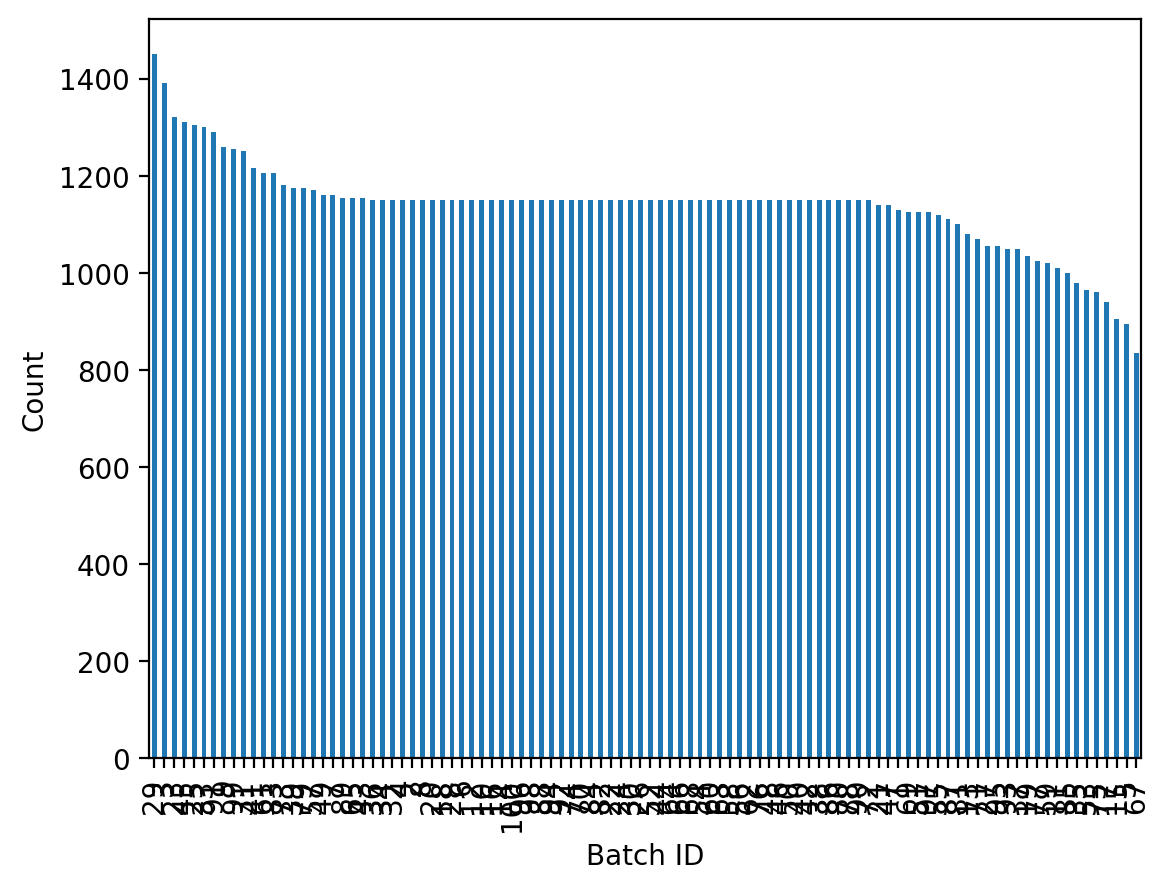

In [8]:
df['Batch ID'].value_counts().plot(kind='bar')
plt.xlabel('Batch ID')
plt.ylabel('Count')
plt.show()
#

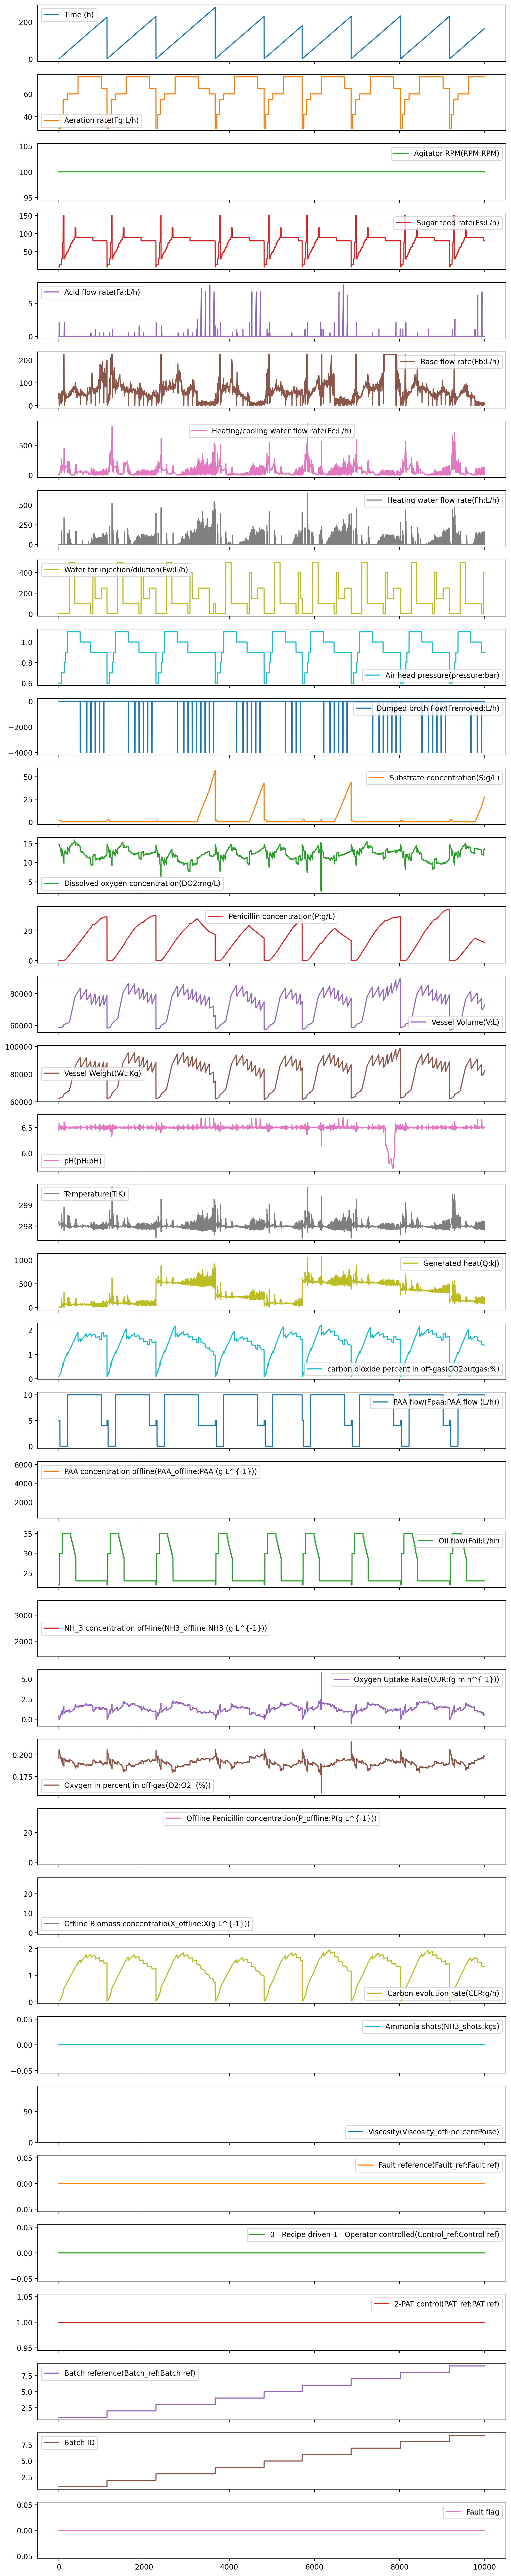

In [15]:
# prompt: df에서 앞의 5000 샘플에 대해서 각 컬럼별로 plot() 를 그려줘

import matplotlib.pyplot as plt
# Plot the first 5000 samples for each column
df.iloc[:10000].plot(subplots=True, figsize=(10, 50))
plt.tight_layout()
plt.show()

<Axes: >

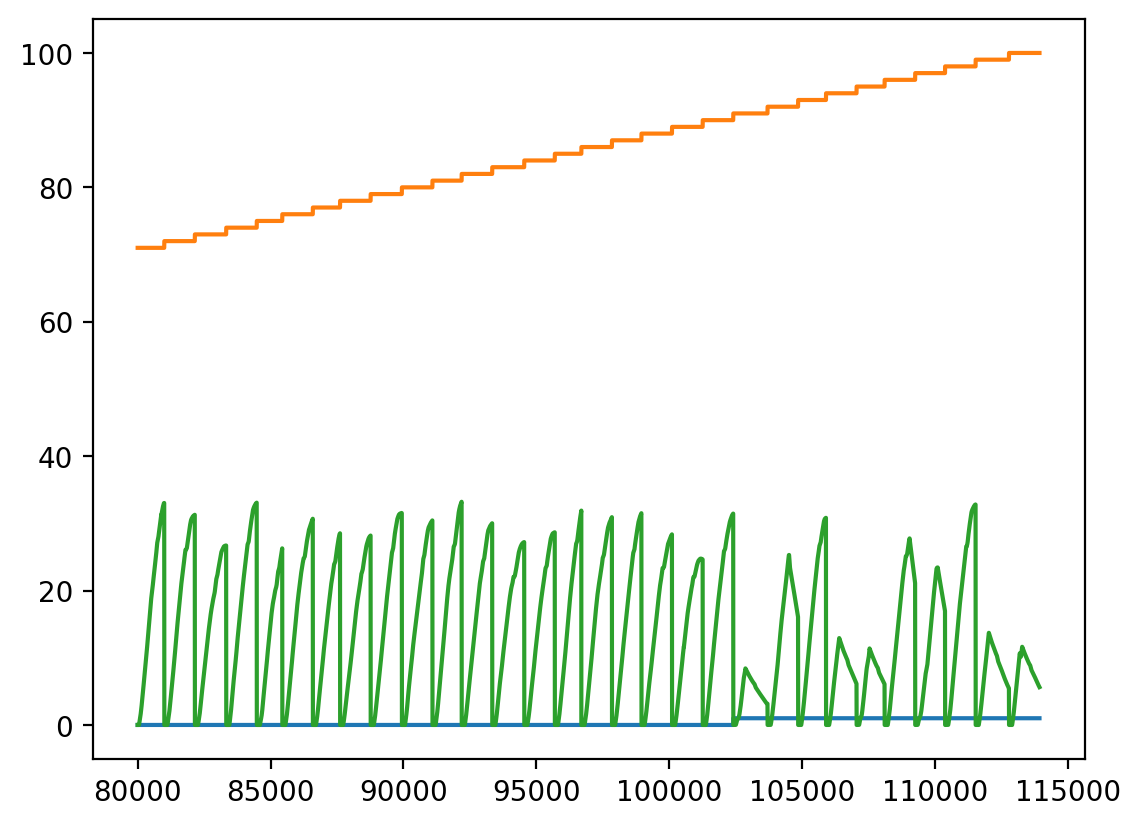

In [39]:
df['Fault flag'][80000:].plot()
df['Batch ID'][80000:].plot()
df["Penicillin concentration(P:g/L)"][80000:].plot()

In [42]:
# prompt: Fault flag가 1일 때의 Batch ID를 찾아줘

faulty_batches = df[df['Fault flag'] == 1]['Batch ID'].unique()
print("Fault flag가 1인 Batch ID 목록:")
faulty_batches


Fault flag가 1인 Batch ID 목록:


array([ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

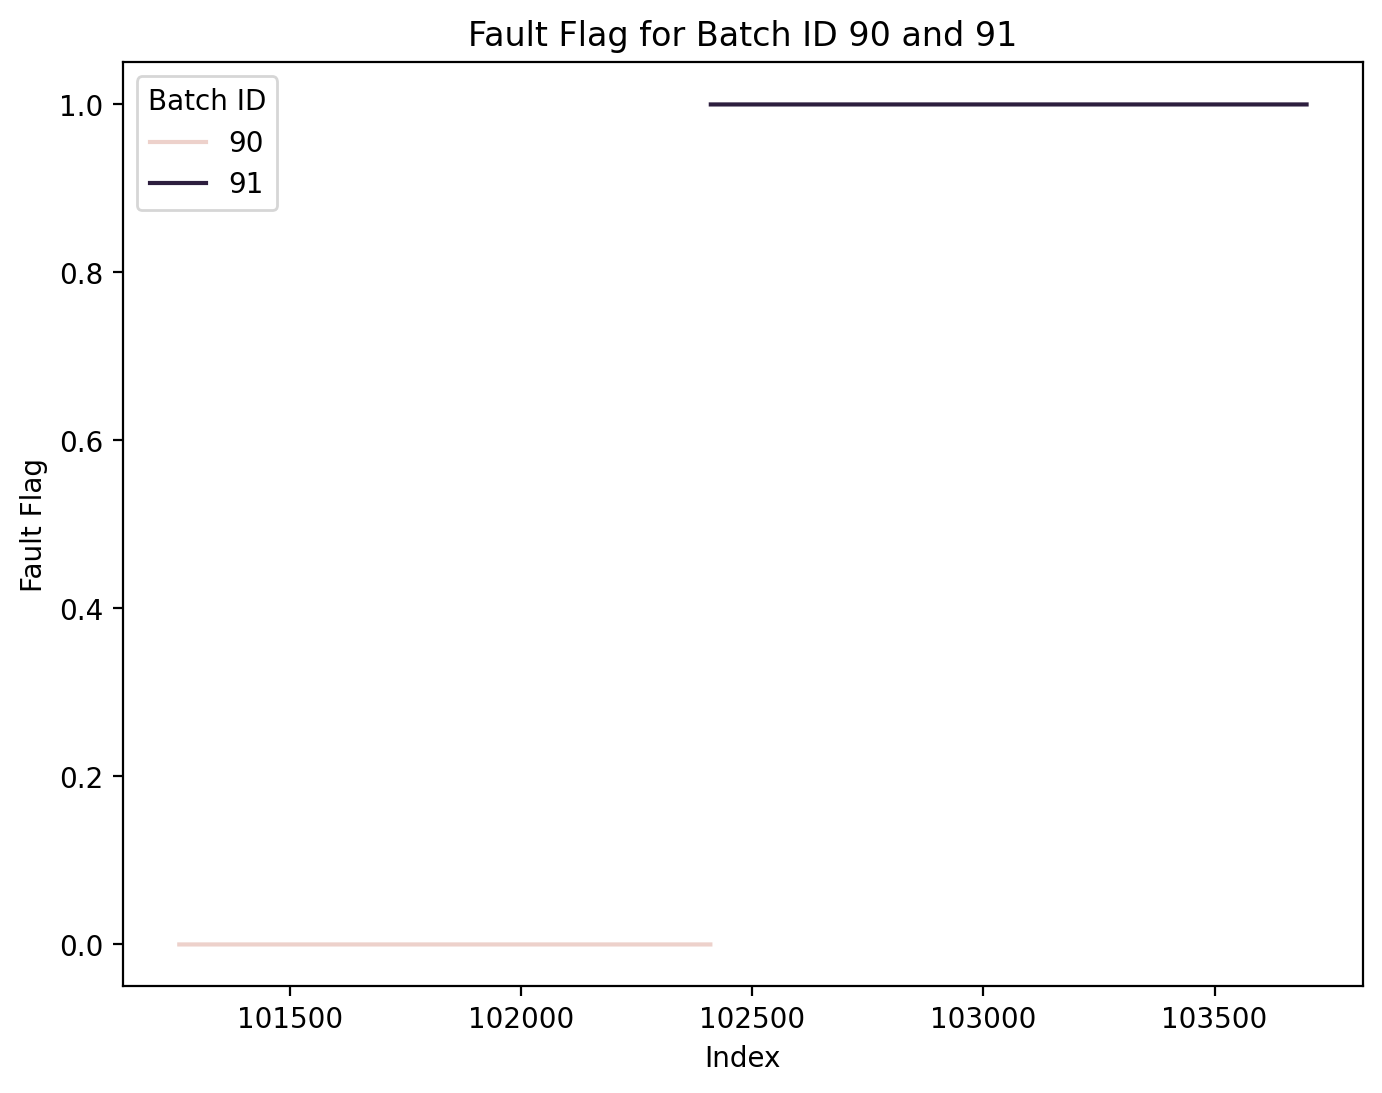

In [53]:
# prompt: Batch ID 가 90 과 91 일때의 Fault flag를 그려줘
import seaborn as sns
import matplotlib.pyplot as plt
# Fault flag를 시각화
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df['Batch ID'].isin([90, 91])], x=df[df['Batch ID'].isin([90, 91])].index, y='Fault flag', hue='Batch ID')
plt.title('Fault Flag for Batch ID 90 and 91')
plt.xlabel('Index')
plt.ylabel('Fault Flag')
plt.show()

In [16]:

# 고유값 개수 확인 (일부 컬럼)
print("\n--- 고유값 개수 (일부 컬럼) ---")
for col in ['Batch id', 'Agitation rate(rpm)', 'Aeration rate(vvm)']: # 예시 컬럼
  if col in df.columns:
    print(f"{col}: {df[col].nunique()}")



--- 고유값 개수 (일부 컬럼) ---



--- Temperature vs Penicillin Concentration ---


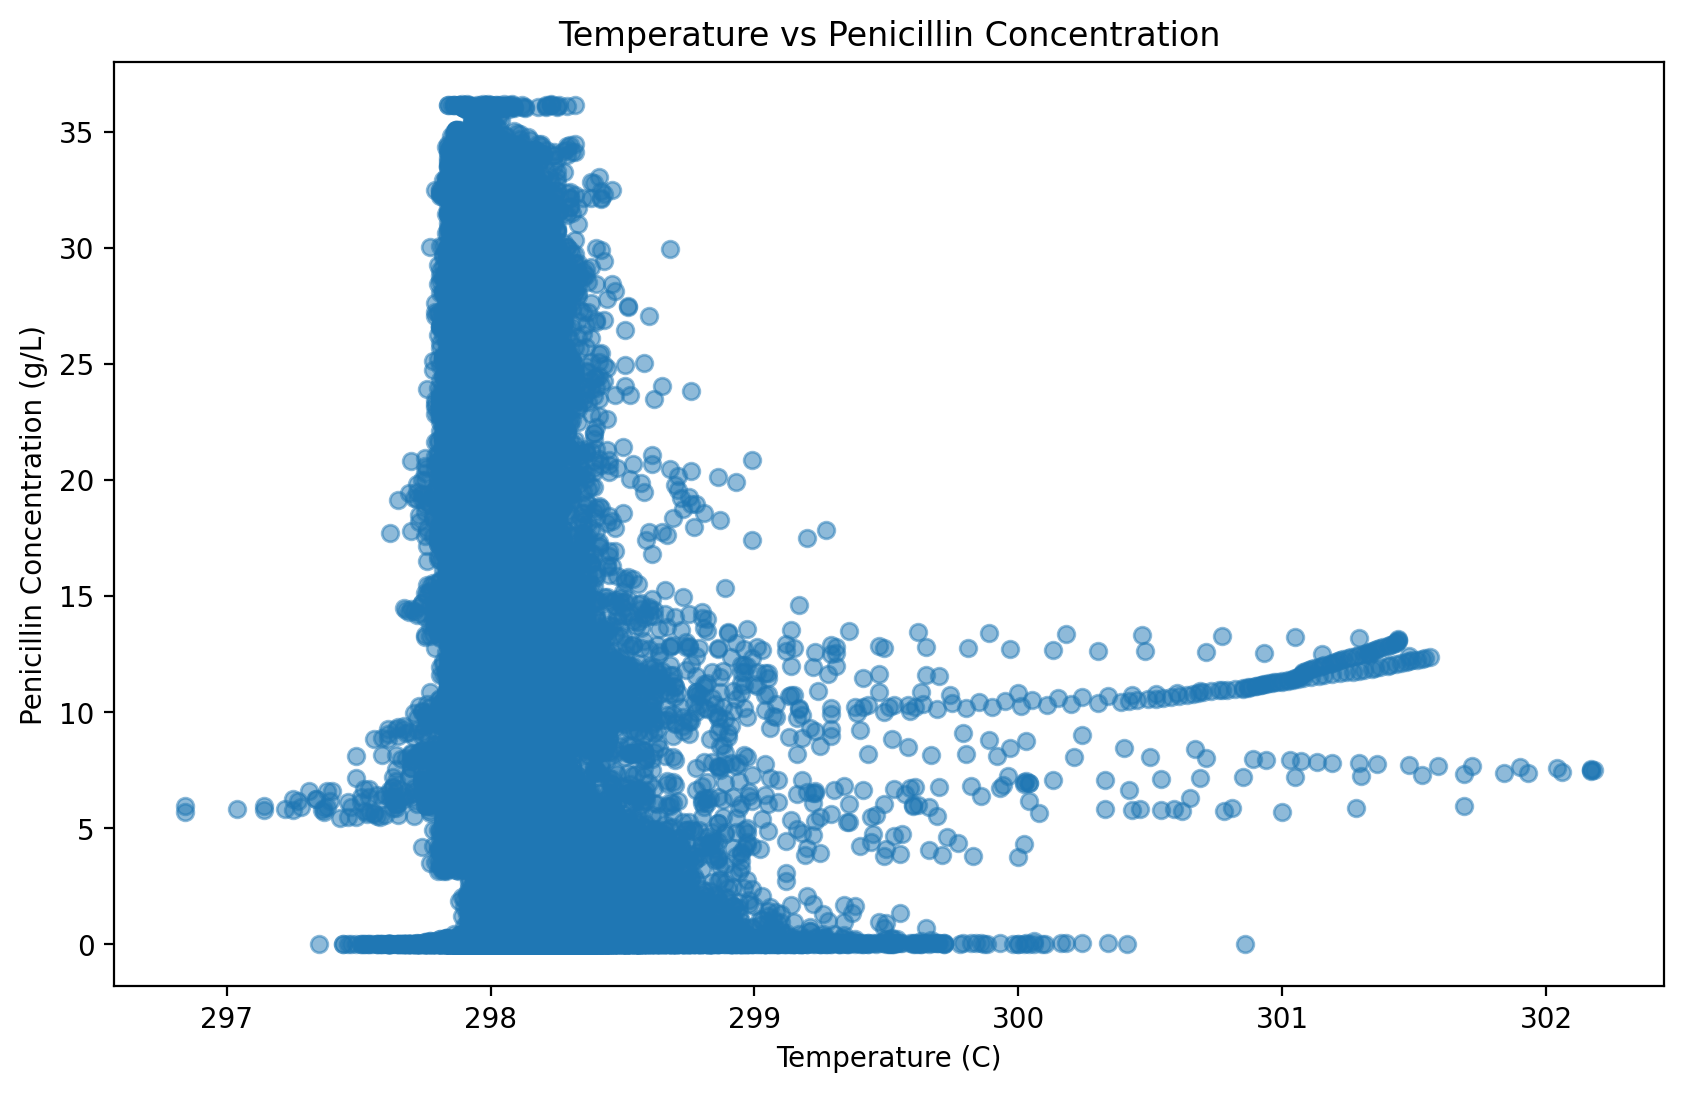

In [26]:

# 특정 변수와 타겟 변수 간의 관계 시각화 (예: Temperature vs Penicillin concentration)
print("\n--- Temperature vs Penicillin Concentration ---")
plt.figure(figsize=(10, 6))
plt.scatter(df['Temperature(T:K)'], df['Penicillin concentration(P:g/L)'], alpha=0.5)
plt.title('Temperature vs Penicillin Concentration')
plt.xlabel('Temperature (C)')
plt.ylabel('Penicillin Concentration (g/L)')
plt.show()


In [29]:
df.columns

Index(['Time (h)', 'Aeration rate(Fg:L/h)', 'Agitator RPM(RPM:RPM)',
       'Sugar feed rate(Fs:L/h)', 'Acid flow rate(Fa:L/h)',
       'Base flow rate(Fb:L/h)', 'Heating/cooling water flow rate(Fc:L/h)',
       'Heating water flow rate(Fh:L/h)',
       'Water for injection/dilution(Fw:L/h)',
       'Air head pressure(pressure:bar)', 'Dumped broth flow(Fremoved:L/h)',
       'Substrate concentration(S:g/L)',
       'Dissolved oxygen concentration(DO2:mg/L)',
       'Penicillin concentration(P:g/L)', 'Vessel Volume(V:L)',
       'Vessel Weight(Wt:Kg)', 'pH(pH:pH)', 'Temperature(T:K)',
       'Generated heat(Q:kJ)',
       'carbon dioxide percent in off-gas(CO2outgas:%)',
       'PAA flow(Fpaa:PAA flow (L/h))',
       'PAA concentration offline(PAA_offline:PAA (g L^{-1}))',
       'Oil flow(Foil:L/hr)',
       'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))',
       'Oxygen Uptake Rate(OUR:(g min^{-1}))',
       'Oxygen in percent in off-gas(O2:O2  (%))',
       'Offline Penicil


--- Time per Batch ---


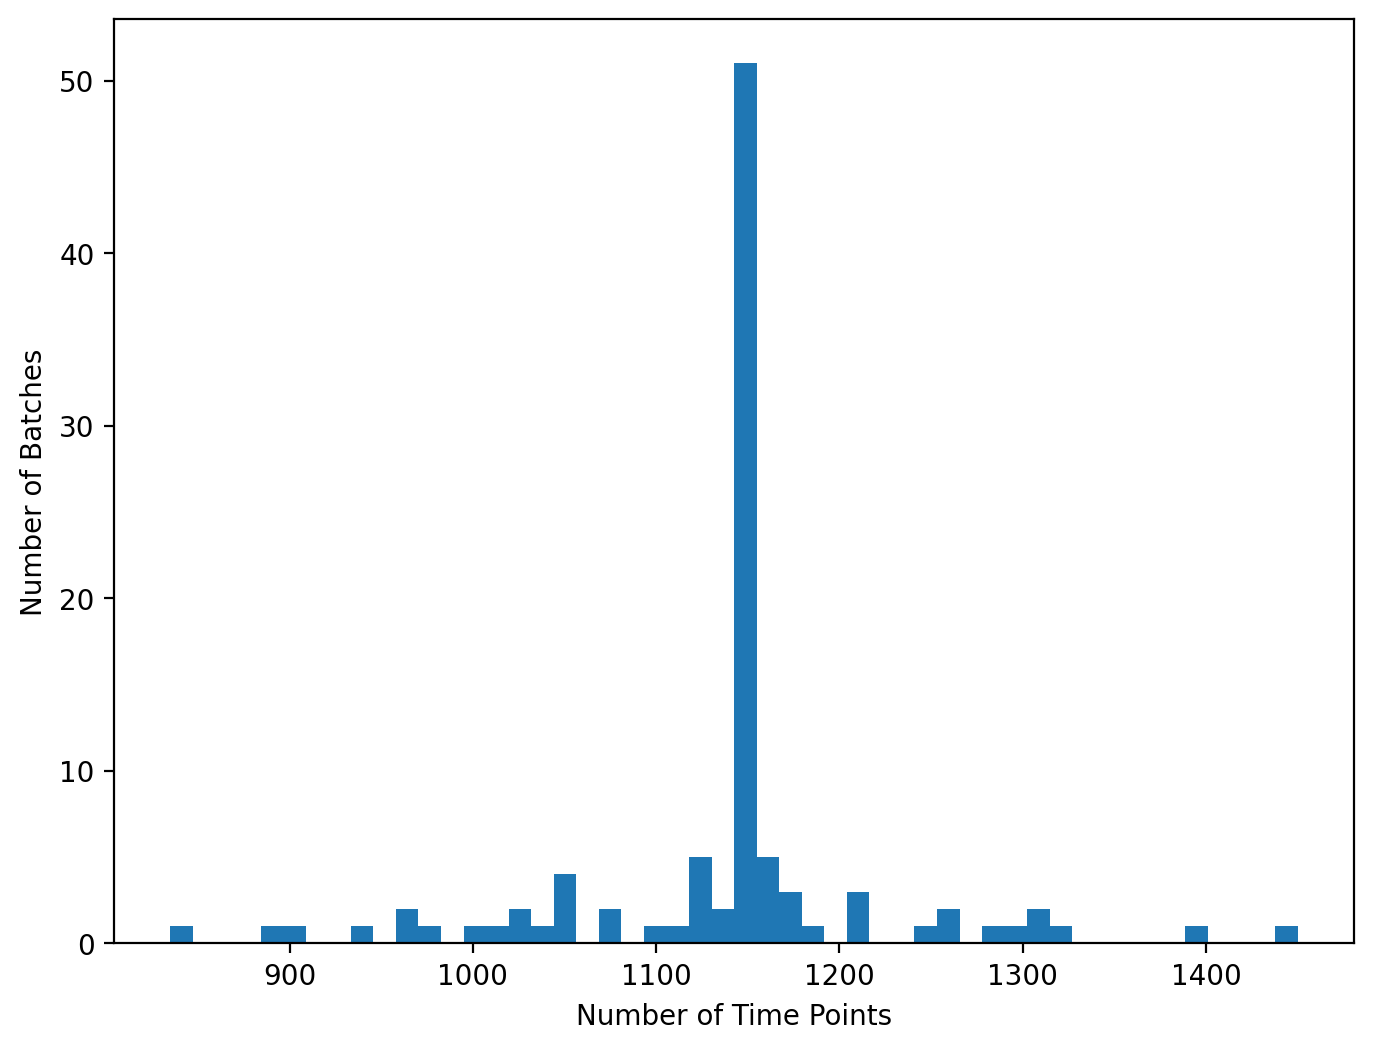

In [31]:

# Batch id 별 Time 분포 확인 (데이터가 시간 경과에 따라 기록되었는지 확인)
print("\n--- Time per Batch ---")
df.groupby('Batch ID')['Time (h)'].nunique().plot(kind='hist', bins=50, figsize=(8, 6))
plt.xlabel('Number of Time Points')
plt.ylabel('Number of Batches')
plt.show()



--- Penicillin Concentration over Time for Sample Batches ---


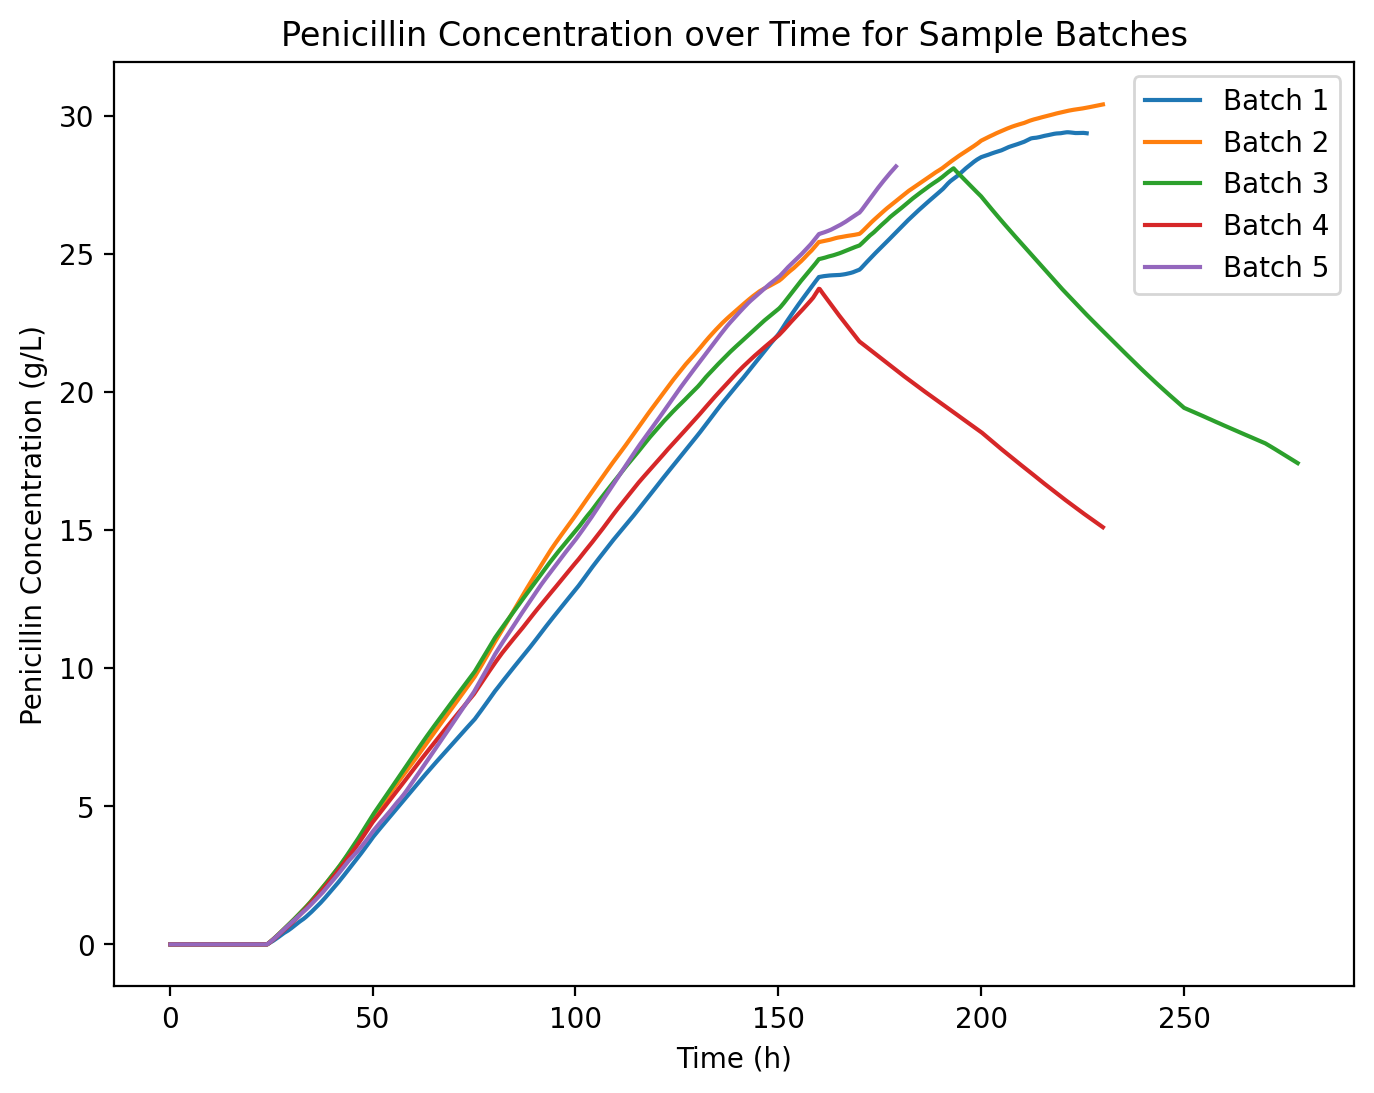

In [34]:

# 각 Batch id 별 타겟 변수의 시간 경과에 따른 변화 시각화 (일부 샘플 배치만)
print("\n--- Penicillin Concentration over Time for Sample Batches ---")
sample_batches = df['Batch ID'].unique()[:5] # 처음 5개 배치만 샘플로 표시

plt.figure(figsize=(8, 6))
for batch_id in sample_batches:
  sns.lineplot(x='Time (h)', y='Penicillin concentration(P:g/L)', data=df[df['Batch ID'] == batch_id], label=f'Batch {batch_id}')
plt.title('Penicillin Concentration over Time for Sample Batches')
plt.xlabel('Time (h)')
plt.ylabel('Penicillin Concentration (g/L)')
plt.legend()
plt.show()

# Batch id를 기준으로 각 변수의 시간 경과에 따른 변화를 추가적으로 시각화하여 패턴을 파악할 수 있습니다.
# 예: pH over Time per Batch
# plt.figure(figsize=(12, 8))
# for batch_id in sample_batches:
#   sns.lineplot(x='Time(h)', y='pH', data=df[df['Batch id'] == batch_id], label=f'Batch {batch_id}')
# plt.title('pH over Time for Sample Batches')
# plt.xlabel('Time (h)')
# plt.ylabel('pH')
# plt.legend()
# plt.show()

In [56]:
# 데이터 분석을 위한 기본 설정
print("📊 데이터 분석을 시작합니다!")

# 예측할 대상 컬럼 이름 정의
TARGET_COLUMN = 'Penicillin concentration(P:g/L)'  # 페니실린 농도 (예측하고 싶은 값)

# 분석에 사용할 공정 변수들 (페니실린 생산에 영향을 주는 요인들)
process_features = [
    'Aeration rate(Fg:L/h)',              # 공기 공급량
    'Agitator RPM(RPM:RPM)',              # 교반기 회전 속도
    'Sugar feed rate(Fs:L/h)',            # 당 공급 속도
    'Acid flow rate(Fa:L/h)',             # 산 공급량
    'Base flow rate(Fb:L/h)',             # 염기 공급량
    'Dissolved oxygen concentration(DO2:mg/L)',  # 용존 산소 농도
    'pH(pH:pH)',                          # pH 값
    'Temperature(T:K)',                   # 온도
    'Substrate concentration(S:g/L)'      # 기질 농도
]

print(f"✅ 분석할 공정 변수 개수: {len(process_features)}개")

📊 데이터 분석을 시작합니다!
✅ 분석할 공정 변수 개수: 9개


In [57]:
# 1단계: 데이터 샘플링 (계산 속도를 위해 전체 데이터의 20%만 사용)
print("\n🔄 데이터 샘플링 중...")
sample_size = int(len(df) * 0.2)  # 전체 데이터의 20%
df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
print(f"   원본 데이터: {len(df)}개 → 샘플링 데이터: {len(df_sample)}개")


🔄 데이터 샘플링 중...
   원본 데이터: 113935개 → 샘플링 데이터: 22787개


In [58]:
# 2단계: 머신러닝을 위한 데이터 구조 만들기
print("\n🛠️ 머신러닝용 데이터 준비 중...")

# 빈 리스트 생성 (데이터를 담을 그릇)
model_data_list = []

# 배치 ID와 시간 순으로 데이터 정렬
df_sorted = df_sample.copy().sort_values(['Batch ID', 'Time (h)'])

# 각 행을 하나씩 확인하면서 데이터 준비
for i in range(len(df_sorted) - 1):  # 마지막 행은 제외 (다음 시점이 없으므로)
    current_row = df_sorted.iloc[i]     # 현재 시점 데이터
    next_row = df_sorted.iloc[i + 1]    # 다음 시점 데이터

    # 같은 배치 내에서만 예측 가능한지 확인
    if current_row['Batch ID'] == next_row['Batch ID']:
        # 새로운 데이터 행 생성
        new_data = {}
        new_data['Batch ID'] = current_row['Batch ID']
        new_data['Time (h)'] = current_row['Time (h)']

        # 현재 시점의 공정 변수들을 입력 변수로 사용
        for feature in process_features:
            new_data[feature] = current_row[feature]

        # 다음 시점의 페니실린 농도를 예측 목표로 설정
        new_data['Target'] = next_row[TARGET_COLUMN]

        # 리스트에 추가
        model_data_list.append(new_data)

model_data_list[0]


🛠️ 머신러닝용 데이터 준비 중...


{'Batch ID': np.float64(1.0),
 'Time (h)': np.float64(0.8),
 'Aeration rate(Fg:L/h)': np.float64(30.0),
 'Agitator RPM(RPM:RPM)': np.float64(100.0),
 'Sugar feed rate(Fs:L/h)': np.float64(8.0),
 'Acid flow rate(Fa:L/h)': np.float64(0.0),
 'Base flow rate(Fb:L/h)': np.float64(37.816),
 'Dissolved oxygen concentration(DO2:mg/L)': np.float64(14.661),
 'pH(pH:pH)': np.float64(6.5753),
 'Temperature(T:K)': np.float64(298.11),
 'Substrate concentration(S:g/L)': np.float64(1.0942),
 'Target': np.float64(0.00098806)}

In [59]:
model_data_list[:3]

[{'Batch ID': np.float64(1.0),
  'Time (h)': np.float64(0.8),
  'Aeration rate(Fg:L/h)': np.float64(30.0),
  'Agitator RPM(RPM:RPM)': np.float64(100.0),
  'Sugar feed rate(Fs:L/h)': np.float64(8.0),
  'Acid flow rate(Fa:L/h)': np.float64(0.0),
  'Base flow rate(Fb:L/h)': np.float64(37.816),
  'Dissolved oxygen concentration(DO2:mg/L)': np.float64(14.661),
  'pH(pH:pH)': np.float64(6.5753),
  'Temperature(T:K)': np.float64(298.11),
  'Substrate concentration(S:g/L)': np.float64(1.0942),
  'Target': np.float64(0.00098806)},
 {'Batch ID': np.float64(1.0),
  'Time (h)': np.float64(4.8),
  'Aeration rate(Fg:L/h)': np.float64(30.0),
  'Agitator RPM(RPM:RPM)': np.float64(100.0),
  'Sugar feed rate(Fs:L/h)': np.float64(15.0),
  'Acid flow rate(Fa:L/h)': np.float64(0.0),
  'Base flow rate(Fb:L/h)': np.float64(22.389),
  'Dissolved oxygen concentration(DO2:mg/L)': np.float64(14.049),
  'pH(pH:pH)': np.float64(6.5223),
  'Temperature(T:K)': np.float64(298.07),
  'Substrate concentration(S:g/L)': 

In [ ]:
# 3단계: 리스트를 데이터프레임으로 변환
model_df = pd.DataFrame(model_data_list)

# 데이터 순서를 랜덤하게 섞기 (모델 학습 성능 향상을 위해)
model_df = model_df.sample(frac=1, random_state=42).reset_index(drop=True)

# 결과 출력
print(f"✅ 머신러닝용 데이터 준비 완료!")
print(f"   총 데이터 포인트: {len(model_data_list)}개")
print(f"   데이터 형태: {model_df.shape}")
print(f"   입력 변수 개수: {len(process_features)}개")

✅ 머신러닝용 데이터 준비 완료!
   총 데이터 포인트: 22687개
   데이터 형태: (22687, 12)
   입력 변수 개수: 9개


In [ ]:
# 준비된 데이터의 처음 5행 확인
print(f"\n📋 준비된 데이터 미리보기:")
model_df.head()


📋 준비된 데이터 미리보기:


,Batch ID,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Dissolved oxygen concentration(DO2:mg/L),pH(pH:pH),Temperature(T:K),Substrate concentration(S:g/L),Target
0,67.0,92.4,75.0,100.0,90.0,0.0,225.000,15.432,5.7262,297.99,0.001215,11.5140
1,27.0,195.2,75.0,100.0,80.0,0.0,72.033,11.272,6.5020,297.85,0.001406,26.1020
2,16.0,107.2,75.0,100.0,90.0,0.0,61.908,11.635,6.5047,297.98,0.000862,16.8940
3,45.0,204.4,65.0,100.0,90.0,0.0,10.209,13.287,6.5088,297.95,51.663000,8.5592
4,59.0,135.4,75.0,100.0,75.0,0.0,50.255,12.845,6.5094,297.95,0.000461,20.6080


## 4. 데이터 준비 및 모델 학습

### 4.1. 피처 이름 정리 (Feature Name Cleanup)

LightGBM 모델은 피처 이름에 JSON에서 사용되는 특수 문자(예: `()[]{},:/-`)가 포함되는 것을 허용하지 않습니다. 오류를 방지하기 위해 정규표현식을 사용하여 컬럼 이름의 특수 문자를 밑줄(`_`)로 변경합니다.

In [ ]:
# 입력(X)과 타겟(y) 분리
X = model_df.drop(columns=['Batch ID', 'Target'])
y = model_df['Target']

# LightGBM이 지원하지 않는 특수 문자를 '_'로 변경
X.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in X.columns]

# 훈련 데이터와 테스트 데이터 분할 (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("정리된 피처 이름 예시:")
print(X_train.columns[:5])
print('---')
print(f"훈련 데이터: {X_train.shape}")
print(f"테스트 데이터: {X_test.shape}")

정리된 피처 이름 예시:
Index(['Time_h_', 'Aeration_rate_Fg_L_h_', 'Agitator_RPM_RPM_RPM_',
       'Sugar_feed_rate_Fs_L_h_', 'Acid_flow_rate_Fa_L_h_'],
      dtype='object')
---
훈련 데이터: (18149, 10)
테스트 데이터: (4538, 10)


### 4.2. 모델 학습 및 평가

In [ ]:
# LightGBM 회귀 모델 초기화 및 학습
print("LightGBM 모델 학습을 시작합니다...")
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
print("모델 학습 완료.")

LightGBM 모델 학습을 시작합니다...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1642
[LightGBM] [Info] Number of data points in the train set: 18149, number of used features: 9
[LightGBM] [Info] Start training from score 14.437029
모델 학습 완료.


In [ ]:
# 테스트 데이터에 대한 예측 수행
predictions = lgbm.predict(X_test)

# 모델 성능 평가
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"평균 절대 오차 (MAE): {mae:.4f}")
print(f"결정 계수 (R²): {r2:.4f}")

평균 절대 오차 (MAE): 0.7119
결정 계수 (R²): 0.9892


### 4.3. 평가 결과 시각화

실제값과 모델의 예측값을 산점도로 비교하여 모델이 얼마나 잘 예측하는지 시각적으로 확인합니다. 점들이 붉은 점선에 가까울수록 예측이 정확하다는 의미입니다.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54168 (\N{HANGUL SYLLABLE PE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45768 (\N{HANGUL SYLLABLE NI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

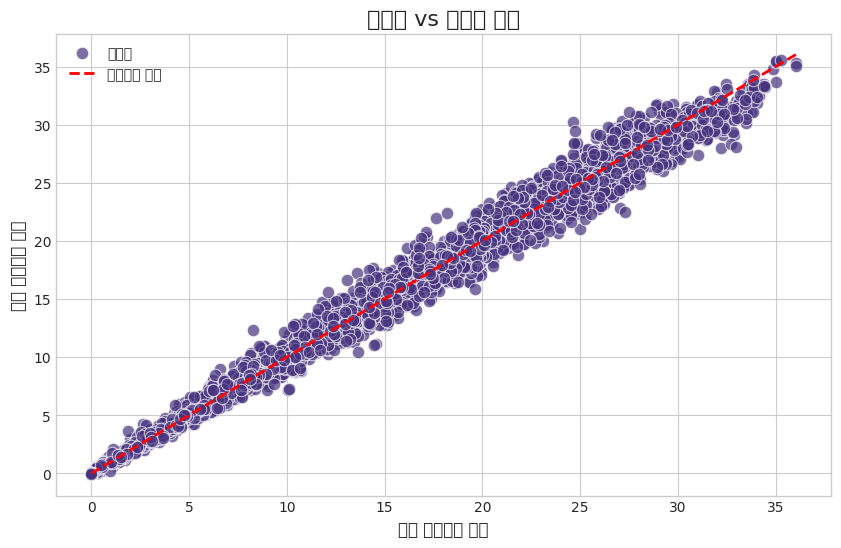

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions, alpha=0.7, s=80, label='예측값')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2, label='이상적인 예측')
plt.title('실제값 vs 예측값 비교', fontsize=16)
plt.xlabel('실제 페니실린 농도', fontsize=12)
plt.ylabel('예측 페니실린 농도', fontsize=12)
plt.legend()
plt.show()

## 5. 특성 중요도 분석

모델이 어떤 공정 변수를 중요하게 사용하여 예측을 수행했는지 확인합니다. 이는 공정 이해도를 높이는 데 도움이 됩니다.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/u

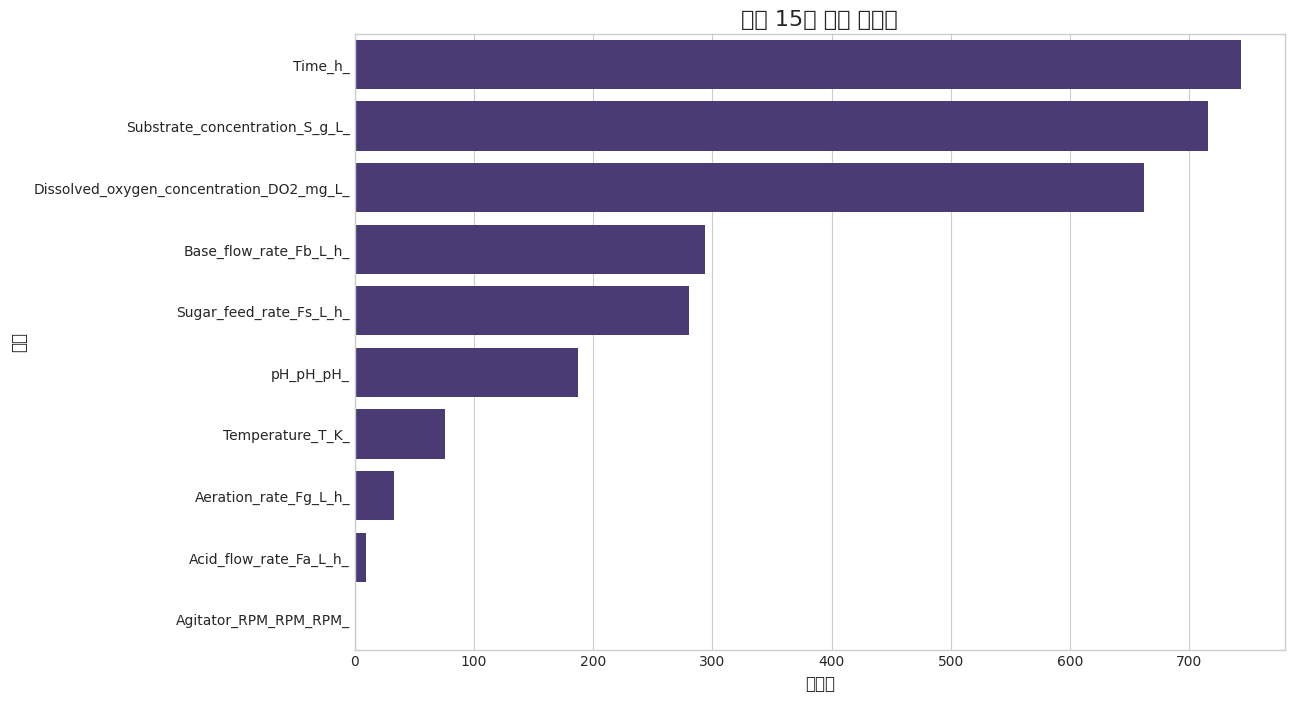

In [ ]:
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': lgbm.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('상위 15개 특성 중요도', fontsize=16)
plt.xlabel('중요도', fontsize=12)
plt.ylabel('특성', fontsize=12)
plt.show()

### 시간 값이 중요한 이유

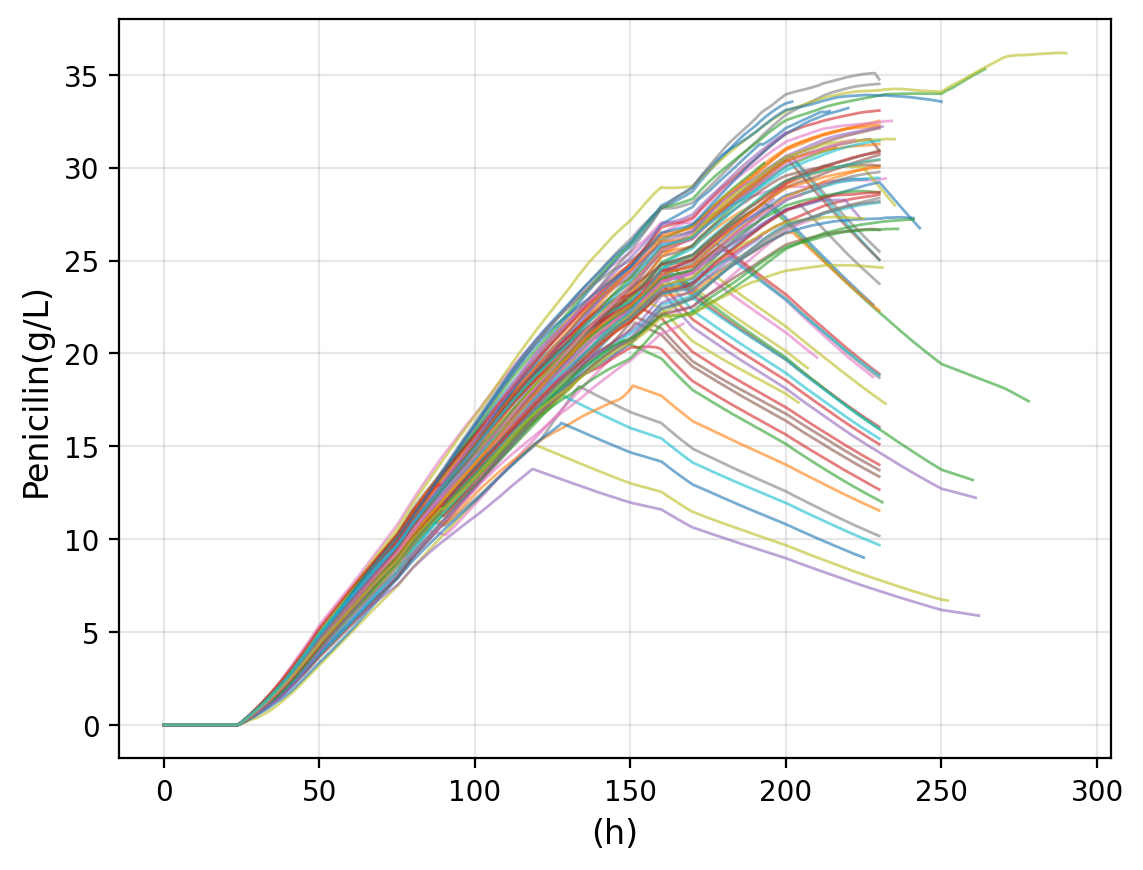

Batch no: 90


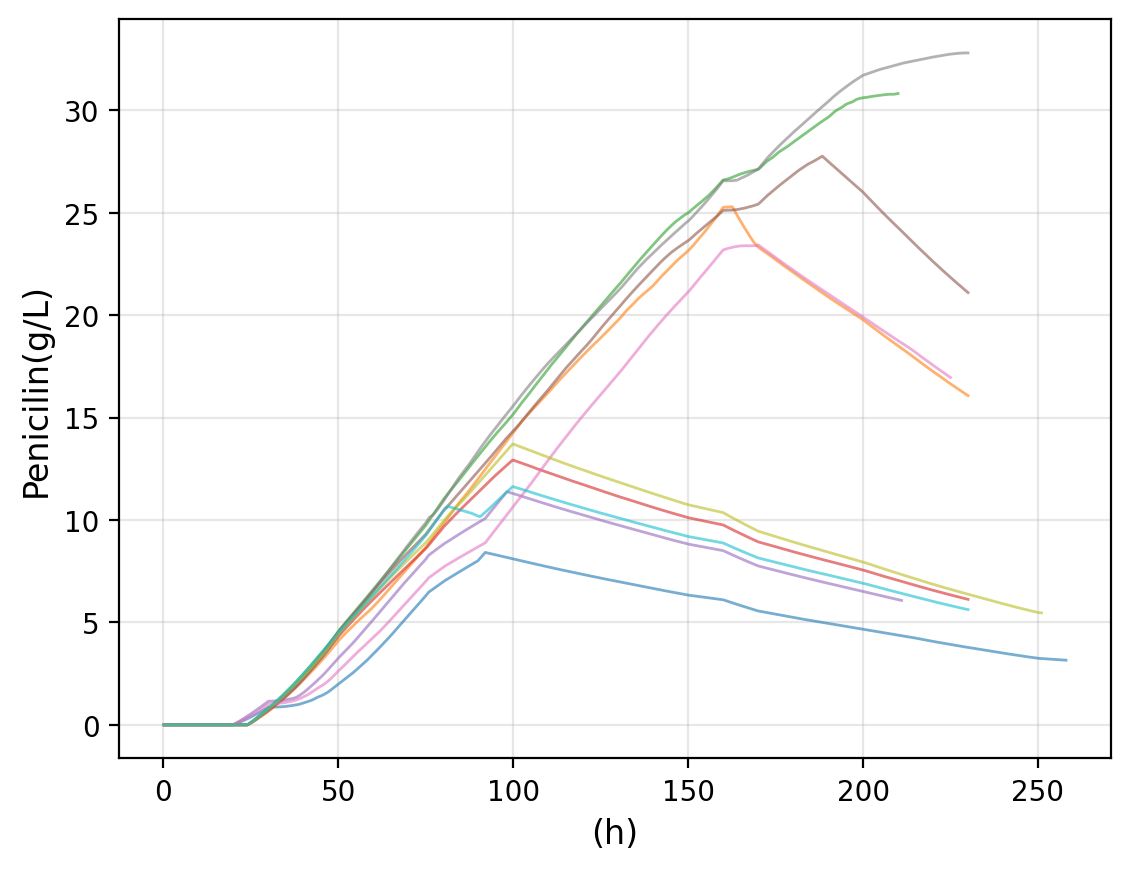

Batch no: 10


In [66]:
# 배치 100개 모두 출력
ok_batches = range(1, 91)
fault_batches = range(91, 101)

# 각 배치의 페니실린 농도 시계열 그래프 출력
# plt.figure(figsize=(10, 6))
for batch_id in ok_batches:
    batch_data = df[df["Batch ID"] == batch_id]
    if not batch_data.empty:
        plt.plot(batch_data["Time (h)"], batch_data["Penicillin concentration(P:g/L)"],
                alpha=0.6, linewidth=1)

plt.xlabel('(h)', fontsize=12)
plt.ylabel('Penicilin(g/L)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Batch no: {len(ok_batches)}")
for batch_id in fault_batches:
    batch_data = df[df["Batch ID"] == batch_id]
    if not batch_data.empty:
        plt.plot(batch_data["Time (h)"], batch_data["Penicillin concentration(P:g/L)"],
                alpha=0.6, linewidth=1)

plt.xlabel('(h)', fontsize=12)
plt.ylabel('Penicilin(g/L)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()
print(f"Batch no: {len(fault_batches)}")


## 6. 결론

이 노트북에서는 페니실린 발효 공정 데이터를 활용하여 페니실린 농도를 예측하는 LightGBM 모델을 성공적으로 구축했습니다.

- **데이터셋**: 100개의 배치로부터 1,130개의 시계열 데이터 포인트를 사용하여 모델을 학습했습니다.
- **주요 변수**: 특성 중요도 분석 결과, `Time` (시간)이 가장 중요한 변수로 나타났으며, 이는 페니실린 발효 공정이 시간에 따라 농도가 변화하는 특성을 잘 반영한 것으로 보입니다.
- **시계열 특성**: 전체 100개 배치의 페니실린 농도 변화 분석을 통해 각 배치마다 고유한 발효 패턴을 가지고 있음을 확인했습니다.